In [1]:
import pandas as pd
from scripts import utils
from scripts import pyrano
from scripts import satimage
from scripts import obssite


import os
from datetime import timezone
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

import xarray as xr
import rioxarray as rxr
import earthaccess
import geopandas as gpd

import seaborn as sns

from datetime import datetime
import pytz


# There are a couple plots that generate errors that we want to ignore.
import warnings
warnings.filterwarnings('ignore')

/home/jose/heliosen/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GET HLS granules

Reading pyranometer values if there is a nc file

In [2]:
PIRA = pyrano.Pyranometer('PAL') # One of PAL (Palaseu), CAB (cabauw) PAY (payerne)

Get HLS https://hls.gsfc.nasa.gov/ data given a central lat lon a diameter start and end dates

In [3]:
center_lat, center_lon = PIRA.description['location']['lat'], PIRA.description['location']['lon']
start_date, end_date = "2017-05-01", "2023-12-30"

satellite = satimage.HLSImage('HLS',center_lat,center_lon,30000,start_date,end_date)


Searching for scenes over AOI
Granules found: 1972


In [4]:
satellite.description

{'long_name': 'Harmonized Landas_Sentinel',
 'providers': {'earth_access': 'cloud_native_nc'},
 'satellite_type': 'POL'}

In [5]:
satellite.satellite_list

size meta.concept-type      meta.concept-id  meta.revision-id  \
0      93.098960           granule  G2211807958-LPCLOUD                 1   
1      35.679668           granule  G2211889915-LPCLOUD                 1   
2     108.020192           granule  G2704982798-LPCLOUD                 1   
3     163.192803           granule  G2704984071-LPCLOUD                 1   
4     204.115494           granule  G2211690193-LPCLOUD                 3   
...          ...               ...                  ...               ...   
1967  218.966215           granule  G2819473301-LPCLOUD                 1   
1968  236.135967           granule  G2820558648-LPCLOUD                 1   
1969  176.954241           granule  G2826081423-LPCLOUD                 1   
1970  231.605654           granule  G2826297713-LPCLOUD                 1   
1971  241.517390           granule  G2826295185-LPCLOUD                 1   

                          meta.native-id meta.collection-concept-id  \
0     HLS.L30.T31UDQ.2017122T104552.v2.0        C2021957657-LPCLOUD   
1     HLS.L30.T31UDP.2017122T104616.v2.0        C2021957657-LPCLOUD   
2     HLS.S30.T31UDP.2017129T105621.v2.0        C2021957295-LPCLOUD   
3     HLS.S30.T31UDQ.2017129T105621.v2.0        C2021957295-LPCLOUD   
4     HLS.L30.T31UDQ.2017131T103949.v2.0        C2021957657-LPCLOUD   
...                                  ...                        ...   
1967  HLS.S30.T31UDQ.2023350T105349.v2.0        C2021957295-LPCLOUD   
1968  HLS.S30.T31UDP.2023350T105349.v2.0        C2021957295-LPCLOUD   
1969  HLS.S30.T31UDQ.2023358T110451.v2.0        C2021957295-LPCLOUD   
1970  HLS.S30.T31UDQ.2023360T105359.v2.0        C2021957295-LPCLOUD   
1971  HLS.S30.T31UDP.2023360T105359.v2.0        C2021957295-LPCLOUD   

     meta.provider-id             meta.format        meta.revision-date  \
0             LPCLOUD  application/echo10+xml  2022-02-04T06:49:52.544Z   
1             LPCLOUD  application/echo10+xml  2022-02-04T12:19:35.585Z   
2             LPCLOUD  application/echo10+xml  2023-06-06T18:35:54.376Z   
3             LPCLOUD  application/echo10+xml  2023-06-06T18:37:47.128Z   
4             LPCLOUD  application/echo10+xml  2022-02-04T01:13:24.745Z   
...               ...                     ...                       ...   
1967          LPCLOUD  application/echo10+xml  2023-12-18T07:35:56.454Z   
1968          LPCLOUD  application/echo10+xml  2023-12-19T23:31:54.468Z   
1969          LPCLOUD  application/echo10+xml  2023-12-28T08:07:50.839Z   
1970          LPCLOUD  application/echo10+xml  2023-12-28T13:22:59.924Z   
1971          LPCLOUD  application/echo10+xml  2023-12-28T13:14:55.255Z   

     umm.TemporalExtent.RangeDateTime.BeginningDateTime  ...  \
0                      2017-05-02 10:45:52.971000+00:00  ...   
1                      2017-05-02 10:46:16.849000+00:00  ...   
2                      2017-05-09 11:05:56.090000+00:00  ...   
3                      2017-05-09 11:05:56.090000+00:00  ...   
4                      2017-05-11 10:39:49.051000+00:00  ...   
...                                                 ...  ...   
1967                   2023-12-16 10:57:27.702000+00:00  ...   
1968                   2023-12-16 10:57:42.161000+00:00  ...   
1969                   2023-12-24 11:07:21.356000+00:00  ...   
1970                   2023-12-26 10:57:29.821000+00:00  ...   
1971                   2023-12-26 10:57:44.272000+00:00  ...   

                                        umm.RelatedUrls  \
0     [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
1     [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
2     [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
3     [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
4     [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
...                                                 ...   
1967  [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
1968  [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
1969  [{'URL': 'https://data.lpda

In [6]:
# Assuming satellite_list is defined elsewhere in your code
df = satellite.satellite_list

# Create a DataFrame with timestamps and native IDs
df = pd.DataFrame({
    'timestamp': pd.to_datetime(df["datetime_group"]),
    'native_id': df["meta.native-id"]
})

df_filtered = df.groupby('timestamp').first().reset_index()   
# Keep only the first occurrence for each day

# Convert Timestamps to datetime objects in UTC and create tuples with native IDs
filtered_datetimes_with_ids = [
    (ts.to_pydatetime().replace(tzinfo=timezone.utc), native_id) 
    for ts, native_id in zip(df_filtered['timestamp'], df_filtered['native_id'])
]

In [7]:
filtered_datetimes_with_ids

[(datetime.datetime(2017, 5, 2, 10, 45, tzinfo=datetime.timezone.utc),
  'HLS.L30.T31UDQ.2017122T104552.v2.0'),
 (datetime.datetime(2017, 5, 2, 10, 46, tzinfo=datetime.timezone.utc),
  'HLS.L30.T31UDP.2017122T104616.v2.0'),
 (datetime.datetime(2017, 5, 9, 11, 5, tzinfo=datetime.timezone.utc),
  'HLS.S30.T31UDP.2017129T105621.v2.0'),
 (datetime.datetime(2017, 5, 11, 10, 39, tzinfo=datetime.timezone.utc),
  'HLS.L30.T31UDQ.2017131T103949.v2.0'),
 (datetime.datetime(2017, 5, 11, 10, 40, tzinfo=datetime.timezone.utc),
  'HLS.L30.T31UDP.2017131T104012.v2.0'),
 (datetime.datetime(2017, 5, 16, 10, 53, tzinfo=datetime.timezone.utc),
  'HLS.S30.T31UDP.2017136T105031.v2.0'),
 (datetime.datetime(2017, 5, 19, 11, 5, tzinfo=datetime.timezone.utc),
  'HLS.S30.T31UDP.2017139T105651.v2.0'),
 (datetime.datetime(2017, 5, 26, 10, 55, tzinfo=datetime.timezone.utc),
  'HLS.S30.T31UDQ.2017146T105031.v2.0'),
 (datetime.datetime(2017, 5, 27, 10, 39, tzinfo=datetime.timezone.utc),
  'HLS.L30.T31UDQ.2017147T103

In [27]:
image = satellite.load_image_from_date(filtered_datetimes_with_ids[15][0], ['B04','B03','B02','Fmask'])


2 scenes for band B04
float32
float32
2 scenes for band B03
float32
float32
2 scenes for band B02
float32
float32
2 scenes for band Fmask
float32
float32


In [28]:
image

<xarray.DataArray (band: 4, y: 1001, x: 1001)> Size: 16MB
array([[[ 500.,  662.,  559., ...,  823., 1148.,  654.],
        [ 555.,  618.,  601., ...,  773.,  974.,  568.],
        [ 581.,  572.,  603., ...,  915., 1155.,  621.],
        ...,
        [ 681.,  473.,  568., ...,  233.,  209.,  224.],
        [ 486.,  570.,  509., ...,  247.,  209.,  214.],
        [ 554.,  469.,  496., ...,  293.,  227.,  223.]],

       [[ 815.,  793.,  733., ...,  765., 1058.,  637.],
        [ 819.,  800.,  764., ...,  732.,  942.,  601.],
        [ 785.,  774.,  777., ...,  826., 1142.,  620.],
        ...,
        [ 713.,  578.,  682., ...,  446.,  396.,  416.],
        [ 614.,  679.,  638., ...,  441.,  391.,  414.],
        [ 666.,  608.,  624., ...,  478.,  412.,  411.]],

       [[ 365.,  421.,  355., ...,  535.,  853.,  469.],
        [ 372.,  415.,  386., ...,  514.,  708.,  439.],
        [ 383.,  390.,  393., ...,  655.,  938.,  484.],
        ...,
        [ 376.,  253.,  312., ...,  125.,  111.,  131.],
        [ 237.,  282.,  268., ...,  122.,  115.,  122.],
        [ 278.,  251.,  272., ...,  142.,  117.,  134.]],

       [[  64.,   64.,   64., ...,  128.,  128.,  128.],
        [  64.,   64.,   64., ...,  128.,  128.,  128.],
        [  64.,   64.,   64., ...,  128.,  128.,  128.],
        ...,
        [  64.,   64.,   64., ...,  128.,   64.,   64.],
        [ 128.,   64.,   64., ...,  128.,  128.,   64.],
        [  64.,   64.,   64., ...,  128.,  128.,   64.]]], dtype=float32)
Coordinates:
  * band         (band) <U5 80B 'B04' 'B03' 'B02' 'Fmask'
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 4.268e+05 4.269e+05 ... 4.568e+05 4.568e+05
  * y            (y) float64 8kB 5.411e+06 5.411e+06 ... 5.381e+06 5.381e+06
Attributes: (12/42)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    AREA_OR_POINT:                                     Area
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    ...                                                ...
    spatial_coverage:                                  45
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_SG...
    ULX:                                               399960
    ULY:                                               5400000
    _FillValue:                                        nan

In [29]:
mask=utils.get_bitmast_from_fmask(image.sel(band="Fmask"))

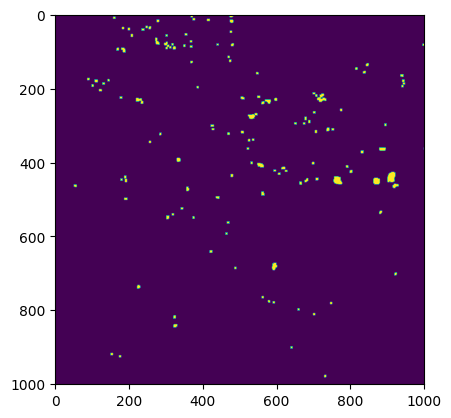

In [30]:
plt.imshow(mask)

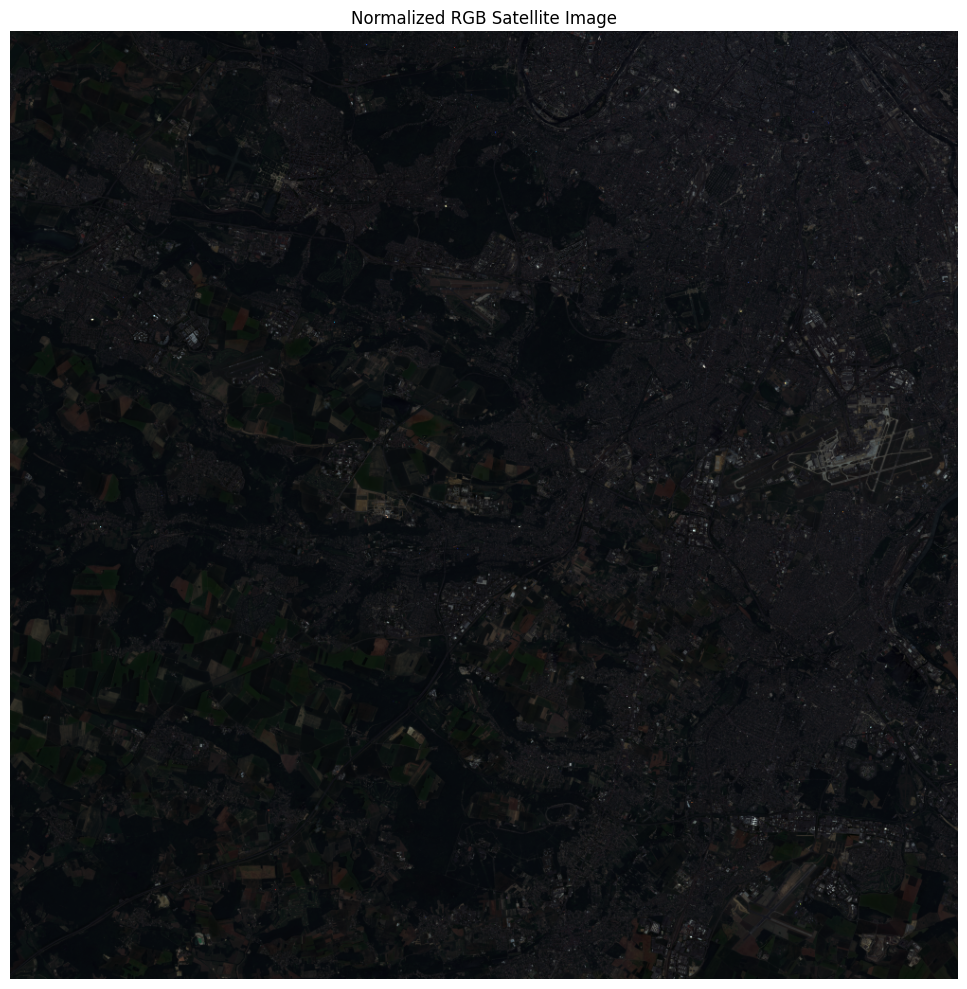

In [31]:
# Assuming your DataArray is named 'satellite_data'
# Extract bands for RGB (using B04=red, B03=green, B02=blue)
red = image.sel(band='B04').values
green = image.sel(band='B03').values
blue = image.sel(band='B02').values

# Stack the bands to create an RGB image
rgb = np.stack([red, green, blue], axis=-1)

# Normalize each band to 0-1 range
# Handle NaN values by setting them to 0 after normalization
def normalize_band(band):
    band_no_nan = np.nan_to_num(band, nan=0)
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    if band_max > band_min:
        normalized = (band_no_nan - band_min) / (band_max - band_min)
    else:
        normalized = np.zeros_like(band_no_nan)
    return normalized

# Apply normalization to each band
rgb_normalized = np.stack([
    normalize_band(red),
    normalize_band(green),
    normalize_band(blue)
], axis=-1)

# Plot the normalized RGB image
plt.figure(figsize=(12, 10))
plt.imshow(rgb_normalized)
plt.title('Normalized RGB Satellite Image')
plt.axis('off')
plt.tight_layout()
plt.show()

# Get pyranometer values matching images

In [19]:
OBSS = obssite.ObsSite(site_name='PAL', pyrano = PIRA, satellites=[satellite],cloudnet_name="") # Change site_name. dates and pyrano values will be sved there. If cloudnet name download cloudnet proucts
OBSS.extract_closest_values(variable='Kt',range_in_minutes=30)

Observation site 'PAL' already exists at /home/jose/termatics/cam2sat/obsite/PAL.
Loading pyraon-polar matche from f/home/jose/termatics/cam2sat/obsite/PAL/matching/pyrano_polar_matches.json
Filtering high variabilit dates
Estimating solar angles


In [5]:
OBSS.pyrano_satellite_matches

[{'date': datetime.datetime(2017, 5, 2, 10, 45, 52, 971000, tzinfo=datetime.timezone.utc),
  'Kt': [0.18653319735296076,
   0.18876972410129714,
   0.1935320904476953,
   0.2008086208526191,
   0.21310997151879005,
   0.23419088641876948,
   0.26652687489081395,
   0.29374954445851253,
   0.44624731618457386,
   0.30040640683603415,
   0.21123458131379924,
   0.19221506057504176,
   0.7652995094078059,
   1.1165028912879473,
   1.113750001507331,
   1.1234364758431787,
   1.1343555073955103,
   1.1440265570967576,
   1.154928063278944,
   1.1645859163120127,
   1.1742387660705549,
   1.185119071336191,
   1.1996837799756632,
   1.210546422274612,
   1.2177207602799742,
   1.2261246257362335,
   1.2418778690608139,
   1.261286190757419,
   0.9959426629008313,
   1.2353405193080933,
   1.1730549904504677,
   0.4007596482076043,
   0.27257658527120315,
   0.25649745397833085,
   0.2404548217934034,
   0.22687425240965736,
   0.2145357981603288,
   0.2022243535776506,
   0.1923588438671068

# Meteosat

Get meteosat archivedata given a datatime a bbox a crs and the inclussion of hvr https://console.cloud.google.com/marketplace/product/bigquery-public-data/eumetsat-seviri-rss?inv=1&invt=AbrwHA&project=tactile-acrobat-249716

In [8]:
buffer_distance = 10000
bbox_gdf=satellite.bbox
gdf_buffer = bbox_gdf.buffer(buffer_distance)
gdf_buffered = gpd.GeoDataFrame(geometry=gdf_buffer)
gdf_buffered.crs = bbox_gdf.crs
bbox_T = gdf_buffered.total_bounds
src_crs_t = gdf_buffered.crs

In [9]:
from scripts import  meteosat
meteosatimag = meteosat.get_subset_meteosat(filtered_datetimes_with_ids[15][0],bbox_T,src_crs_t,'no_hvr')

In [10]:
meteosatimag

<xarray.DataArray 'data' (y_geostationary: 9, x_geostationary: 17, variable: 11)> Size: 3kB
dask.array<getitem, shape=(9, 17, 11), dtype=float16, chunksize=(9, 17, 11), chunktype=numpy.ndarray>
Coordinates:
    time             datetime64[ns] 8B 2017-06-18T11:05:00
  * variable         (variable) <U6 264B 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * x_geostationary  (x_geostationary) float64 136B -4.801e+05 ... -5.281e+05
  * y_geostationary  (y_geostationary) float64 72B 4.459e+06 ... 4.483e+06
Attributes: (12/204)
    IR_016__satpy_id:                              !!python/object/apply:satp...
    IR_016_ancillary_variables:                    []
    IR_016_area:                                   msg_seviri_rss_3km:\n  des...
    IR_016_calibration:                            reflectance
    IR_016_end_time:                               2017-01-01T00:00:11.206426
    IR_016_georef_offset_corrected:                False
    ...                                            ...
    orbital_parameters:                            projection_altitude: 35785...
    platform_name:                                 Meteosat-9
    reader:                                        seviri_l1b_native
    resolution:                                    3000.403165817
    sensor:                                        seviri
    start_time:                                    2016-12-31T23:55:11.074565

Probqbly not the best way of reading and projecting but just for illustration

In [11]:
from rasterio.crs import CRS

sample = meteosatimag.sel(variable=['VIS006', 'VIS008','IR_134'])

proj_dict = meteosat.GEOSTATIONARY_3KM_PROJ_SPEC['projection']
crs = CRS(proj_dict)
proj_string = crs.to_proj4()

sample = sample.astype('float32')
sample = sample.transpose('variable', 'y_geostationary', 'x_geostationary')
sample.rio.set_spatial_dims(x_dim ='x_geostationary',y_dim ='y_geostationary')
sample.rio.write_crs(proj_string, inplace=True)
target_proj = CRS.from_epsg(32631)
repro_sample = sample.rio.reproject(target_proj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


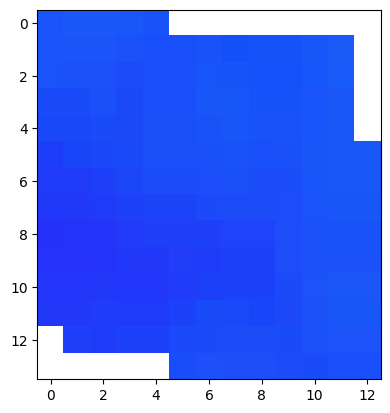

In [16]:
plt.imshow(repro_sample.values.transpose(2,1,0))